In [3]:
import math
from scipy import stats
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

import pystan
import arviz as az


<hr>

## Coin Tosses 

Let's imagine we are trying to determine if a coin is fair. We are going to need a model and some data.

### Model Construction

STAN models, like the following, require three main blocks to function:
- **Data**: Defines variable names and the dimension  
- **Parameters**: Defines names and limits of parameters in the model
- **Model**: Defines the distribution statement

In [4]:
coin_model = """
data {
    int<lower=0> n; // number of tosses
    int<lower=0> y; // number of heads
}
transformed data {}
parameters {
    real<lower=0, upper=1> p;
}
transformed parameters {}
model {
    p ~ beta(2, 2);      // Beta prior
    y ~ binomial(n, p);  // Likelihood, binomial
}
generated quantities {}
"""

Now let's compile the STAN model using the [STAN API](https://pystan.readthedocs.io/en/latest/api.html). Note: this is often the most computationally intensive part of model building, so we don't want to do this if we have already done it before.

In [5]:
try:
    model
except NameError:    
    model = pystan.StanModel(model_code=coin_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_10712a7d77f64051032e04ecdf3651ce NOW.


Ok, let's imagine we have some data about some coin tosses 

In [7]:
coin_dat = {
             'n': 100, # number of tosses
             'y': 61,  # number of heads
            }

We can use the coin_data to fit the model by sampling from the data.

In [8]:
fit = model.sampling(data=coin_dat)
#
# Default options:
#
# chains - 4
# iter   - 2000
# warmup - 1000

### Model Evaluation

Let's take a look at how our model performed

In [9]:
fit

Inference for Stan model: anon_model_10712a7d77f64051032e04ecdf3651ce.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.61  1.1e-3   0.05   0.51   0.57   0.61   0.64    0.7   1915    1.0
lp__ -70.22    0.02   0.69 -72.24 -70.37 -69.97  -69.8 -69.74   1854    1.0

Samples were drawn using NUTS at Wed Nov 18 10:06:20 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

- **p** is the parameter we are trying to understand
- The density of the out-of-sample data across posterior draws is known as the (out of sample) log posterior (**lp_**) density of a datapoint.

<hr>*Notice* the mean of the prior is 0.61 (the same as the ratio of heads) 

If either of the following statements are not true, we may have poor mixing (we didn't explore the sample space very thoroughly):
1. `Rhat` should be close to 1.
2. `n_eff` should not be massively smaller than the number of iterations.

<hr>

Additionally, we can view the sampled value of p for each used iteration of the 4 chains


In [10]:
fit['p']

array([0.65413247, 0.64263608, 0.55226558, ..., 0.56913081, 0.67814974,
       0.66792775])

In [11]:
len(fit['p'])

4000

There are 4000 values here because: $(iter - warmup)*chains$
<hr>

Pystan also provides some functions to check for potential issues (False is bad!)

In [12]:
pystan.diagnostics.check_div(fit)

True

In [13]:
pystan.diagnostics.check_treedepth(fit)

True

In [14]:
pystan.diagnostics.check_energy(fit)

True

Now, lets look at the distribution of the posterior for each chain (left plot). We will also look at the trace of each chain (right plot), which helps us to understand how the values of p change between iterations (samples).

/Users/isaaccaruso/opt/miniconda3/envs/thesis/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/isaaccaruso/opt/miniconda3/envs/thesis/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/isaaccaruso/opt/miniconda3/envs/thesis/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/isaaccaruso/opt/miniconda3/envs/thesis/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38:

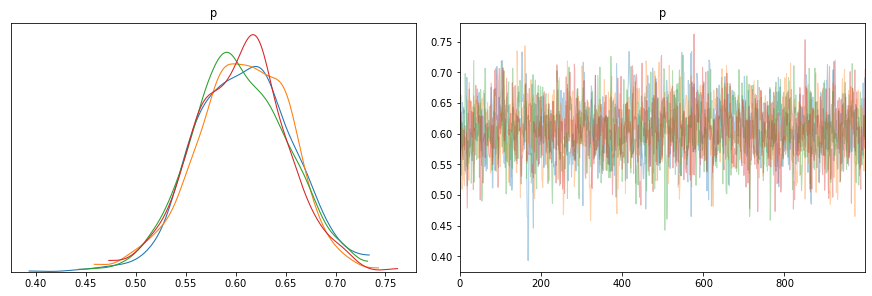

In [16]:
az.plot_trace(fit, figsize = (12, 4));

How does the posterior density look? Let's see: 

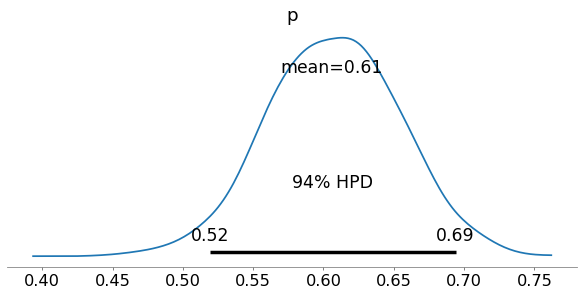

In [23]:
az.plot_posterior(fit, figsize = (8, 4));

We can also extract samples from different parameters (like the posterior)

In [19]:
samples = fit.extract('p')
samples

OrderedDict([('p',
              array([0.65413247, 0.64263608, 0.55226558, ..., 0.56913081, 0.67814974,
                     0.66792775]))])

We don't really need the dictionary wrapper for our example...

In [25]:
p = samples['p']
p

array([0.65413247, 0.64263608, 0.55226558, ..., 0.56913081, 0.67814974,
       0.66792775])

Samples for different parameters can also be extracted as a pandas dataframe:

In [21]:
p_df = fit.to_dataframe('p')
p_df

,chain,draw,warmup,p,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.555551,0.854979,0.895975,1,3,0,71.518203
1,0,1,0,0.564542,1.000000,0.895975,1,1,0,70.276368
2,0,2,0,0.576403,1.000000,0.895975,1,1,0,70.075470
3,0,3,0,0.572461,0.971820,0.895975,2,3,0,70.251364
4,0,4,0,0.616731,0.953743,0.895975,2,3,0,70.424487
...,...,...,...,...,...,...,...,...,...,...
3995,3,995,0,0.608263,0.998945,1.124550,1,3,0,69.772542
3996,3,996,0,0.626206,0.977034,1.124550,2,3,0,69.890907
3997,3,997,0,0.656551,0.904646,1.124550,1,3,0,70.326500
3998,3,998,0,0.576470,0.890660,1.124550,2,3,0,71.250682


<hr>

Now we can use samples to evaluate our hypothesis

In [22]:
(p > 0.5).mean()

0.987

In ~98% of iterations we found p to be greater than 0.5. This means that in 98.7% of our "experiments" we found the coin to be 'unfair'   